In [ ]:
"""
Para superar o probelam da prmeira implementação, foi criado a ferramenta chamada ControlNet que é uma arquitetura de rede neural que adiciona um condicionamento espacial extra e explícito aos modelos de difusão pré-treinados.
"""

In [1]:
%pip install -q torch torchvision --index-url https://download.pytorch.org/whl/cu124
%pip install -q diffusers transformers accelerate pillow requests opencv-python numpy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import torch                    #Fundamental para o DeepLearning
import cv2
import numpy as np
from PIL import Image           #Importa uma função de utilidade para carregar facilmente imagens a partir de URLs ou caminhos de arquivo.
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
from diffusers.utils import load_image

c:\Users\igorg\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


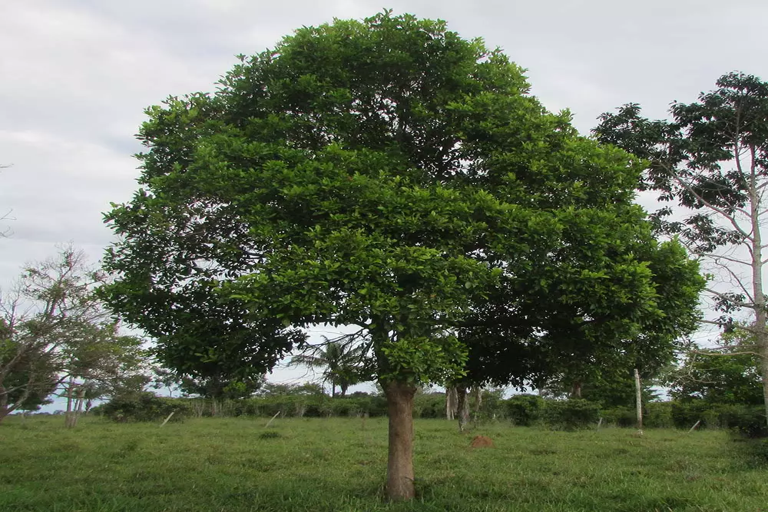

In [4]:
# Vamos primeiro carregar a imagem de conteúdo

image = load_image("C:\\Users\\igorg\\Documents\\PDSI\\imagens\\Imagem1.webp").resize((768,512))

# Converte o objeto PIL para um array NumPy. O OpenCV (cv2) e o NumPy trabalham bem com arrays numéricos de pixels.

image_np = np.array(image)

display(image)

In [5]:
"""
Aqui é a parte de préprocessamento para gerar o mapa das arestas do ControlNet, Converter a imagem original em um mapa de bordas que o ControlNet pode usar como guia.
"""

low = 100   #Limite inferior para o Canny, pixels com gradiente menor que isso são descartados.

high = 200  #Limiar superior para o algoritmo Canny. Pixels com gradiente maior que isso são considerados bordas.

canny_map = cv2.Canny(image_np, low, high) # Aplica o detector de bordas Canny à imagem. O resultado `canny_map` é uma imagem em escala de cinza onde as bordas são brancas (255) e o fundo é preto (0).

canny_map = canny_map[:, :, None]

In [6]:
# O ControlNet, assim como muitas redes neurais de imagem, espera uma entrada com 3 canais (RGB).

canny_map = np.concatenate([canny_map, canny_map, canny_map], axis=2)

# Converte o array NumPy (com 3 canais Canny) de volta para um objeto PIL Image.
# Esta será a "imagem de controle" passada para o pipeline do ControlNet.

control_image = Image.fromarray(canny_map)

In [7]:
# Carregar o modelo ControlNet pré-treinado para arestas Canny

controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)

# Carregar o pipeline de difusão estável com o ControlNet

pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", 
    controlnet=controlnet,           # Injeca o modelo ControlNet carregado anteriormente no pipeline.
    torch_dtype=torch.float16       
)

c:\Users\igorg\AppData\Local\Programs\Python\Python313\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\igorg\.cache\huggingface\hub\models--lllyasviel--sd-controlnet-canny. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Fa

In [8]:
# O UniPC é conhecido por ser mais rápido e eficiente, permitindo bons resultados com menos etapas de inferência.

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

# Uma otimização de memória. Partes do modelo são movidas para a memória RAM (CPU) quando não estão sendo usadas ativamente.

pipe.enable_model_cpu_offload()

In [9]:
# Definir o prompt de estilo

prompt = "make this cartoon style tree"

In [10]:
# Executar a inferência, passando a imagem de controle
# Cria um gerador de números aleatórios.
# device="cpu": Embora o pipeline rode na GPU, a seed inicial é definida na CPU para garantir reprodutibilidade.

generator = torch.Generator(device="cpu").manual_seed(1)

output_image = pipe(
    prompt,                  
    num_inference_steps=20,  # O número de etapas que o agendador usará para remover o ruído. 20 é um bom balanço entre velocidade e qualidade com UniPC.
    generator=generator,     
    image=control_image 
).images[0]

output_image.save("testecontrolnet.png")


100%|██████████| 20/20 [04:11<00:00, 12.58s/it]


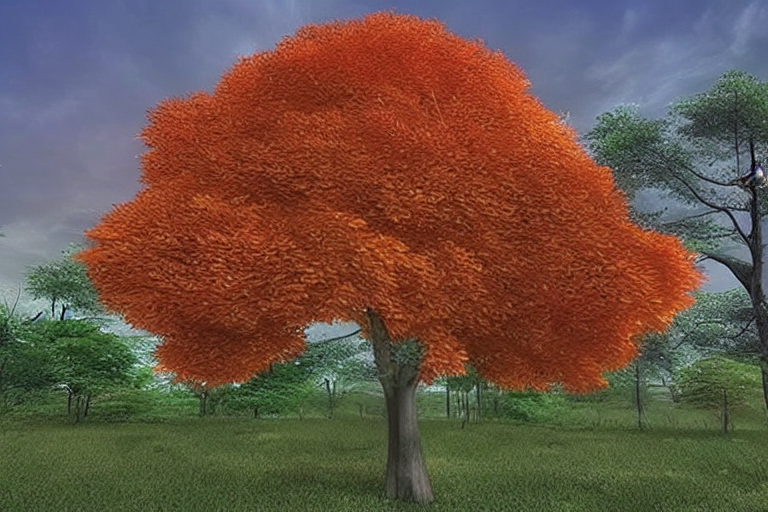

In [11]:
display(output_image)